# 1. Imports and global configuration

In [231]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from ultralytics import YOLO
import string


# 2. Load & explore Chars74K dataset

In [232]:
# Root directory for Chars74K English/Fnt subset
DATASET_DIR = "./English/Fnt"
CSV_PATH = "./chars74k_labels.csv"

print("Dataset directory:", DATASET_DIR)

samples = sorted(os.listdir(DATASET_DIR))
rows = []

for sample in samples:
    if not sample.startswith("Sample"):
        continue

    # Extract sample number
    try:
        num = int(sample.replace("Sample", ""))
    except ValueError:
        continue

    # Mapping based on Chars74K structure:
    # Sample001–Sample010 -> digits 0–9
    # Sample011–Sample036 -> uppercase A–Z
    if 1 <= num <= 10:
        label = str(num - 1)
    elif 11 <= num <= 36:
        label = chr(ord("A") + (num - 11))
    else:
        # ignore lowercase and others
        continue

    folder = os.path.join(DATASET_DIR, sample)
    for fname in os.listdir(folder):
        if fname.lower().endswith(".png"):
            rows.append({
                "path": os.path.join(sample, fname),
                "label": label
            })

df = pd.DataFrame(rows)
df.to_csv(CSV_PATH, index=False)

print(f"CSV generated with {len(df)} samples at {CSV_PATH}")
df.head()


Dataset directory: ./English/Fnt
CSV generated with 36576 samples at ./chars74k_labels.csv


,path,label
0,Sample001/img001-00006.png,0
1,Sample001/img001-00007.png,0
2,Sample001/img001-00008.png,0
3,Sample001/img001-00009.png,0
4,Sample001/img001-00010.png,0


# 3. Exploración rápida del dataset

In [233]:
# print("Unique labels:", sorted(df["label"].unique()))
print("Total samples:", len(df))
print(df["label"].value_counts().sort_index().head(20))


Total samples: 36576
label
0    1016
1    1016
2    1016
3    1016
4    1016
5    1016
6    1016
7    1016
8    1016
9    1016
A    1016
B    1016
C    1016
D    1016
E    1016
F    1016
G    1016
H    1016
I    1016
J    1016
Name: count, dtype: int64


# 4. Definición del mapeo de etiquetas y Dataset OCR

In [234]:
# Character set: digits 0–9 + uppercase A–Z
digits = "0123456789"
uppercase = string.ascii_uppercase

char_to_label = {d: i for i, d in enumerate(digits)}  # 0–9 -> 0–9
for i, ch in enumerate(uppercase, start=10):
    char_to_label[ch] = i                             # A–Z -> 10–35

label_to_char = {v: k for k, v in char_to_label.items()}

NUM_CLASSES = len(char_to_label)
print("Num classes:", NUM_CLASSES)

transform_ocr = T.Compose([
    T.Resize((32, 32)),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

class CharsDataset(Dataset):
    def __init__(self, df, root_dir=DATASET_DIR, transform=None):
        self.df = df.reset_index(drop=True)
        self.root = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.root, row["path"])
        label_char = row["label"]
        label_idx = char_to_label[label_char]

        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label_idx


Num classes: 36


# 5. Split train / test

In [235]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df, test_size=0.15, stratify=df["label"], random_state=42
)

len(train_df), len(test_df)


(31089, 5487)

# 6. Definición del modelo CNN OCR

In [236]:
class OCRNet(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 256), nn.ReLU(),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = OCRNet().to(device)
print(model)


OCRNet(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=36, bias=True)
  )
)


# 7. DataLoaders

In [237]:
train_ds = CharsDataset(train_df, transform=transform_ocr)
test_ds  = CharsDataset(test_df,  transform=transform_ocr)

train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl  = DataLoader(test_ds,  batch_size=64, shuffle=False)


# 8. Entrenamiento del modelo OCR

In [238]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

epochs = 5  # ajusta si quieres más
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    print(f"Epoch {epoch+1}/{epochs} - loss: {avg_loss:.4f}")


Epoch 1/5 - loss: 0.5600
Epoch 2/5 - loss: 0.1738
Epoch 3/5 - loss: 0.1090
Epoch 4/5 - loss: 0.0815
Epoch 5/5 - loss: 0.0624


# 9. Evaluación en test

In [239]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"New OCR accuracy with synthetic data: {test_acc:.4f}")


New OCR accuracy with synthetic data: 0.9728


# 10. Guardar modelo OCR

In [240]:
OCR_MODEL_PATH = "ocr_model.pt"
torch.save(model.state_dict(), OCR_MODEL_PATH)
print("OCR model saved at", OCR_MODEL_PATH)


OCR model saved at ocr_model.pt


# Bonus - datos sintéticos

In [209]:
import os
import random
from PIL import Image, ImageDraw, ImageFont, ImageFilter
import numpy as np
import pandas as pd

FONT_PATH = "./fonts/StatePlate.ttf"   # <- tu font en el repo

def generate_synthetic_char_128(char, idx):
    """
    Generate a synthetic character (digit or uppercase letter)
    at 128x128 with perfect centering using mask-based alignment.
    """

    canvas_size = 128

    # Step 1: create blank temporary canvas
    temp = Image.new("L", (canvas_size, canvas_size), color=255)
    draw_temp = ImageDraw.Draw(temp)

    try:
        font = ImageFont.truetype(FONT_PATH, size=120)
    except:
        font = ImageFont.load_default()

    # Step 2: initial draw at (0,0)
    draw_temp.text((0, 0), char, fill=0, font=font)

    # Step 3: convert to mask to find actual digit/letter pixels
    arr = np.array(temp)
    ys, xs = np.where(arr < 250)   # character pixels

    if len(xs) == 0 or len(ys) == 0:
        # Fallback, should not happen
        center_x, center_y = canvas_size//2, canvas_size//2
    else:
        center_x = (xs.min() + xs.max()) // 2
        center_y = (ys.min() + ys.max()) // 2

    # Step 4: recentering
    shift_x = canvas_size//2 - center_x
    shift_y = canvas_size//2 - center_y

    # Step 5: draw final centered char
    canvas = Image.new("L", (canvas_size, canvas_size), color=255)
    draw = ImageDraw.Draw(canvas)
    draw.text((shift_x, shift_y), char, fill=0, font=font)

    # Step 6: small rotation
    angle = random.randint(-3, 3)
    canvas = canvas.rotate(angle, expand=False, fillcolor=255)

    # Step 7: optional blur
    if random.random() < 0.3:
        canvas = canvas.filter(ImageFilter.GaussianBlur(radius=1))

    # Step 8: save
    path = os.path.join(SYNTH_DIR, f"{char}_{idx}.png")
    canvas.save(path)

    return path


In [210]:
SYNTH_DIR = "./synthetic_chars"
os.makedirs(SYNTH_DIR, exist_ok=True)

samples_per_char = 500
synthetic_rows = []

# Digits + uppercase letters
classes = list("0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ")

for ch in classes:
    print("Generating:", ch)
    for i in range(samples_per_char):
        path = generate_synthetic_char_128(ch, i)
        synthetic_rows.append({"path": path.replace("./", ""), "label": ch})

df_synth = pd.DataFrame(synthetic_rows)
df_synth.to_csv("./synthetic_chars.csv", index=False)

print("Synthetic characters generated:", len(df_synth))
df_synth.head()


Generating: 0
Generating: 1
Generating: 2
Generating: 3
Generating: 4
Generating: 5
Generating: 6
Generating: 7
Generating: 8
Generating: 9
Generating: A
Generating: B
Generating: C
Generating: D
Generating: E
Generating: F
Generating: G
Generating: H
Generating: I
Generating: J
Generating: K
Generating: L
Generating: M
Generating: N
Generating: O
Generating: P
Generating: Q
Generating: R
Generating: S
Generating: T
Generating: U
Generating: V
Generating: W
Generating: X
Generating: Y
Generating: Z
Synthetic characters generated: 18000


,path,label
0,synthetic_chars/0_0.png,0
1,synthetic_chars/0_1.png,0
2,synthetic_chars/0_2.png,0
3,synthetic_chars/0_3.png,0
4,synthetic_chars/0_4.png,0


In [211]:
model.load_state_dict(torch.load("ocr_model.pt"))

train_df_ft, test_df_ft = train_test_split(
    df_synth, test_size=0.1, stratify=df_synth["label"]
)

train_ds_ft = CharsDataset(train_df_ft, root_dir=".", transform=transform_ocr)
test_ds_ft  = CharsDataset(test_df_ft,  root_dir=".", transform=transform_ocr)

train_dl_ft = DataLoader(train_ds_ft, batch_size=64, shuffle=True)
test_dl_ft  = DataLoader(test_ds_ft,  batch_size=64)


In [212]:
for epoch in range(3):
    model.train()
    total_loss = 0
    for x, y in train_dl_ft:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print("FT epoch", epoch+1, "loss=", total_loss / len(train_dl_ft))


FT epoch 1 loss= 0.04387014824771011
FT epoch 2 loss= 0.014946497240590526
FT epoch 3 loss= 0.0008784618448843266


In [213]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_dl:
        x, y = x.to(device), y.to(device)
        out = model(x)
        pred = out.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

test_acc = correct / total
print(f"Test accuracy: {test_acc:.4f}")

Test accuracy: 0.9271


# 11. Utilidad: normalización de recortes de caracteres

In [241]:
transform_base = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

def prepare_char_normalized(char_gray: np.ndarray):
    """
    Normalize a character crop so it matches training distribution:
      - Otsu binarization
      - ensure dark text on light background
      - crop to tight bounding box
      - resize to 32x32
      - convert to tensor with same normalization
    """
    # 1) Binarize
    _, bin_img = cv2.threshold(
        char_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # 2) Ensure text is dark / background light
    white = np.sum(bin_img == 255)
    black = np.sum(bin_img == 0)
    if black < white:
        # invert so text is dark
        bin_img = 255 - bin_img

    # 3) Crop to non-white region
    coords = cv2.findNonZero(255 - bin_img)
    if coords is None:
        crop = bin_img
    else:
        x, y, w, h = cv2.boundingRect(coords)
        crop = bin_img[y:y+h, x:x+w]

    # 4) Resize to 32x32
    crop_resized = cv2.resize(crop, (32, 32), interpolation=cv2.INTER_AREA)

    # 5) To tensor
    pil = Image.fromarray(crop_resized).convert("L")
    tensor = transform_base(pil).unsqueeze(0)  # [1,1,32,32]
    return tensor


# 12. Carga del modelo YOLO para detectar matrículas

In [242]:
# Replace with your actual YOLO weights for license plate detection
YOLO_WEIGHTS_PATH = "license_plate_detector.pt"

yolo_model = YOLO(YOLO_WEIGHTS_PATH)
print("YOLO plate detector loaded.")


YOLO plate detector loaded.


# 13. Función de detección de matrícula (ROI)

In [243]:
def detect_plate_yolo(img_path, conf_threshold=0.4, debug=False):
    """
    Detect a license plate in a full vehicle image using YOLO.
    Returns (plate_roi_bgr, bbox) or None.
    bbox = (x1, y1, x2, y2)
    """
    img = cv2.imread(img_path)
    if img is None:
        print("Could not read image:", img_path)
        return None

    results = yolo_model(img, verbose=False)
    for r in results:
        for box in r.boxes:
            conf = float(box.conf[0])
            if conf < conf_threshold:
                continue
            x1, y1, x2, y2 = map(int, box.xyxy[0].tolist())
            roi = img[y1:y2, x1:x2]
            if debug:
                plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
                plt.title(f"Detected plate ROI (conf={conf:.2f})")
                plt.axis("off")
                plt.show()
            return roi, (x1, y1, x2, y2)

    return None


# 14. Segmentación robusta de caracteres desde un ROI gris

In [244]:
def segment_characters(plate_gray, debug=False):
    """
    Extrae regiones de caracteres individuales desde una ROI de matrícula gris.
    Utiliza binarización + contornos + heurísticas robustas.
    """
    # 1) Binarizar
    _, thresh = cv2.threshold(
        plate_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    inv = 255 - thresh

    h_img, w_img = inv.shape

    # 2) Contornos externos (caracteres individuales)
    contours, _ = cv2.findContours(
        inv, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    char_regions = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)

        # Heurísticas que te han funcionado bien
        if h < 0.3 * h_img or h > 0.95 * h_img:
            continue
        if w < 0.02 * w_img or w > 0.30 * w_img:
            continue

        char_regions.append((x, y, w, h))

    # Ordenar por posición horizontal
    char_regions = sorted(char_regions, key=lambda r: r[0])

    # Debug visual opcional
    if debug:
        plt.figure(figsize=(10, 3))
        for i, (x, y, w, h) in enumerate(char_regions):
            crop = plate_gray[y:y+h, x:x+w]
            plt.subplot(1, len(char_regions), i+1)
            plt.imshow(crop, cmap="gray")
            plt.axis("off")
        plt.suptitle("Character crops from plate ROI")
        plt.show()

    return char_regions


# 15. OCR sobre una ROI de matrícula

In [245]:
transform_base = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5]),
])

def prepare_char_normalized(char_gray):
    """
    Convierte un recorte real de matrícula en un dígito/letra
    con el estilo visual de Chars74K.
    """
    # 1) Binarizar
    _, bin_img = cv2.threshold(
        char_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Asegurar fondo blanco y letra negra
    if np.sum(bin_img == 0) > np.sum(bin_img == 255):
        bin_img = 255 - bin_img

    # 2) Bounding box ajustado
    coords = cv2.findNonZero(255 - bin_img)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        crop = bin_img[y:y+h, x:x+w]
    else:
        crop = bin_img

    # 3) Resize manteniendo proporción (lado máx 24px)
    target = 32
    h0, w0 = crop.shape
    scale = 24 / max(h0, w0)
    new_w = max(1, int(w0 * scale))
    new_h = max(1, int(h0 * scale))
    resized = cv2.resize(crop, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # 4) Centrar en canvas 32x32
    canvas = np.ones((target, target), dtype=np.uint8) * 255
    y_off = (target - new_h) // 2
    x_off = (target - new_w) // 2
    canvas[y_off:y_off+new_h, x_off:x_off+new_w] = resized

    # 5) A tensor
    pil = Image.fromarray(canvas).convert("L")
    return transform_base(pil).unsqueeze(0)

def ocr_plate_roi(plate_gray, debug=False, conf_th=0.35):
    """
    Aplica OCR a una ROI de matrícula gris.
    Usa:
      - segmentación robusta (punto 14)
      - normalización tipo Chars74K
      - tu modelo CNN ya entrenado
    """
    regions = segment_characters(plate_gray, debug=debug)
    if not regions:
        return None

    model.eval()
    predicted = []

    for idx, (x, y, w, h) in enumerate(regions):
        crop = plate_gray[y:y+h, x:x+w]

        tensor = prepare_char_normalized(crop).to(device)

        with torch.no_grad():
            logits = model(tensor)
            probs = torch.softmax(logits, dim=1)
            max_prob, label_idx = probs.max(dim=1)

        char = label_to_char[label_idx.item()]
        prob = max_prob.item()

        if debug:
            print(f"[DEBUG] idx={idx} → char={char}  prob={prob:.2f}")

            vis = tensor.squeeze().cpu().numpy()
            vis = vis * 0.5 + 0.5
            plt.imshow(vis, cmap="gray")
            plt.title(f"OCR Input ({char}, {prob:.2f})")
            plt.axis("off")
            plt.show()

        if prob >= conf_th:
            predicted.append(char)

    return "".join(predicted) if predicted else None


# 16. Pipeline completo: de imagen de vehículo a string de matrícula

In [246]:
def read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=False):
    res = detect_plate_yolo(img_path, conf_threshold=conf_threshold, debug=debug)
    if res is None:
        print("No plate detected by YOLO.")
        return None

    plate_roi_bgr, bbox = res
    plate_gray = cv2.cvtColor(plate_roi_bgr, cv2.COLOR_BGR2GRAY)
    return read_plate_from_roi(plate_gray, debug=debug, conf_char_threshold=0.6)


# 17. Pruebas rápidas con tus imágenes

Image: test_plate_001.jpg


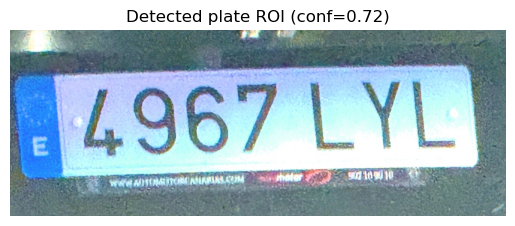

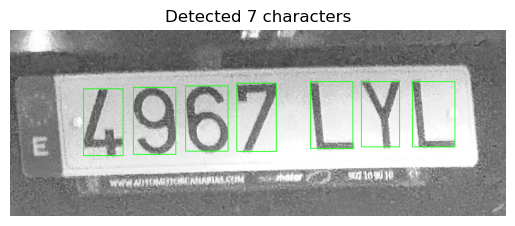

[WARN] Skipping region #0 at x=277,w=149: low confidence 0.50 for 'Q'

[DEBUG] Character candidates (after confidence filtering):
  idx=0, x=277, w=149, h=251, char='Q', prob=0.50
  idx=1, x=465, w=160, h=251, char='9', prob=0.99
  idx=2, x=662, w=160, h=245, char='6', prob=0.98
  idx=3, x=855, w=149, h=256, char='7', prob=1.00
  idx=4, x=1133, w=160, h=251, char='L', prob=1.00
  idx=5, x=1325, w=144, h=245, char='Y', prob=1.00
  idx=6, x=1518, w=160, h=245, char='L', prob=1.00
Final plate string: 967LYL
Predicted plate: 967LYL
--------------------------------------------------
Image: test_plate_002.jpeg


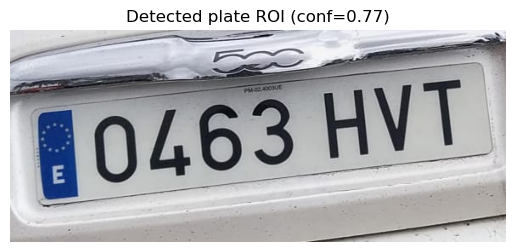

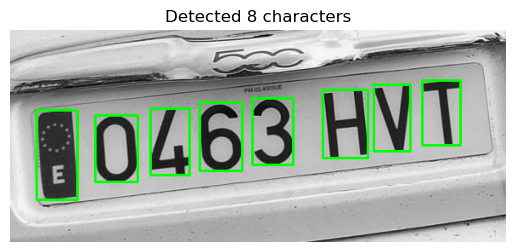


[DEBUG] Character candidates (after confidence filtering):
  idx=0, x=31, w=48, h=105, char='Q', prob=0.98
  idx=1, x=100, w=50, h=78, char='0', prob=0.61
  idx=2, x=165, w=46, h=78, char='L', prob=0.79
  idx=3, x=223, w=50, h=80, char='6', prob=1.00
  idx=4, x=285, w=48, h=78, char='3', prob=1.00
  idx=5, x=368, w=53, h=80, char='H', prob=1.00
  idx=6, x=428, w=43, h=78, char='N', prob=0.73
  idx=7, x=485, w=45, h=76, char='T', prob=1.00
Final plate string: Q0L63HNT
Predicted plate: Q0L63HNT
--------------------------------------------------


In [247]:
test_images = [
    "test_plate_001.jpg",
    "test_plate_002.jpeg"
]

for img_path in test_images:
    print("Image:", img_path)
    plate = read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=True)
    print("Predicted plate:", plate)
    print("-" * 50)


Image: test_plate_001.jpg


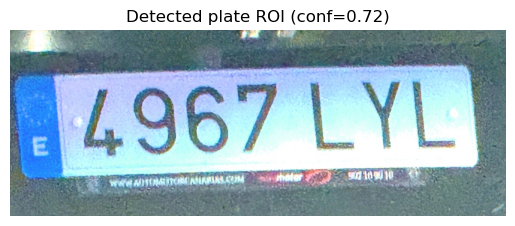

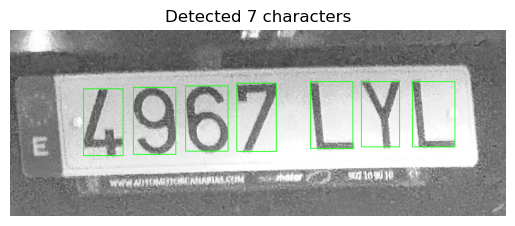

[WARN] Skipping region #0 at x=277,w=149: low confidence 0.50 for 'Q'

[DEBUG] Character candidates (after confidence filtering):
  idx=0, x=277, w=149, h=251, char='Q', prob=0.50
  idx=1, x=465, w=160, h=251, char='9', prob=0.99
  idx=2, x=662, w=160, h=245, char='6', prob=0.98
  idx=3, x=855, w=149, h=256, char='7', prob=1.00
  idx=4, x=1133, w=160, h=251, char='L', prob=1.00
  idx=5, x=1325, w=144, h=245, char='Y', prob=1.00
  idx=6, x=1518, w=160, h=245, char='L', prob=1.00
Final plate string: 967LYL
Predicted plate: 967LYL
--------------------------------------------------
Image: test_plate_002.jpeg


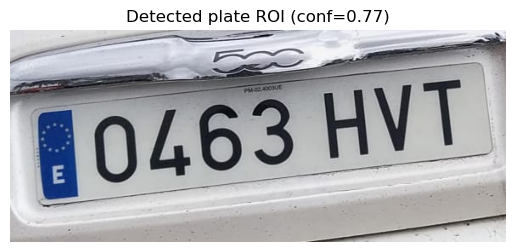

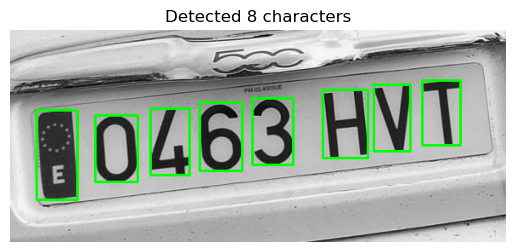


[DEBUG] Character candidates (after confidence filtering):
  idx=0, x=31, w=48, h=105, char='Q', prob=0.98
  idx=1, x=100, w=50, h=78, char='0', prob=0.61
  idx=2, x=165, w=46, h=78, char='L', prob=0.79
  idx=3, x=223, w=50, h=80, char='6', prob=1.00
  idx=4, x=285, w=48, h=78, char='3', prob=1.00
  idx=5, x=368, w=53, h=80, char='H', prob=1.00
  idx=6, x=428, w=43, h=78, char='N', prob=0.73
  idx=7, x=485, w=45, h=76, char='T', prob=1.00
Final plate string: Q0L63HNT
Predicted plate: Q0L63HNT
--------------------------------------------------


In [248]:
test_images = [
    "test_plate_001.jpg",
    "test_plate_002.jpeg"
]

for img_path in test_images:
    print("Image:", img_path)
    plate = read_plate_from_vehicle(img_path, conf_threshold=0.4, debug=True)
    print("Predicted plate:", plate)
    print("-" * 50)
